In [66]:
%matplotlib inline

from pyproj import Proj, transform
from bokeh.io import output_notebook
from bokeh.plotting import show, figure
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import ColumnDataSource
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from itertools import product
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Bokeh init
output_notebook()
tile_provider = get_provider(Vendors.CARTODBPOSITRON)

Loading BokehJS ...

Good resource for datasets: [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php)

# PART 1. Pandas and Boston dataset

First we will look at a simple dataset using Pandas.

In [67]:
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['target'] = boston.target

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
target     506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


In [69]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


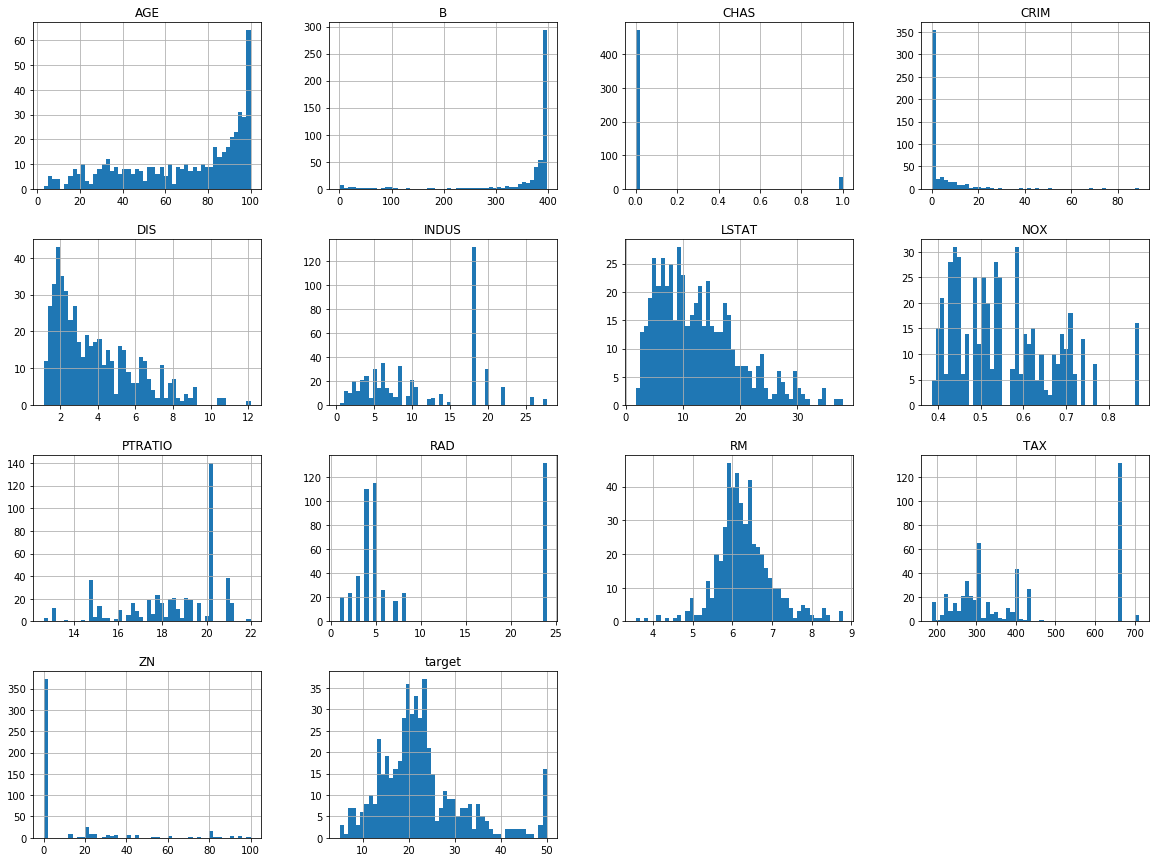

In [70]:
df.hist(bins=50, figsize=(20,15))
plt.show()

What can you tell about the data?

## Train and Test split

We will randomly split data into train and test sets to prevent overfitting.

In [71]:
np.random.seed(42)
mask = np.random.rand(df.shape[0]) <= 0.7

print('Train set shape {0}, test set shape {1}'.format(df[mask].shape, df[~mask].shape))

Train set shape (351, 14), test set shape (155, 14)


## Linear model

In [72]:
lr = LinearRegression()
lr.fit(df.iloc[mask, :-1], df.iloc[mask, -1])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's make prediction on test set and evaluate it using MSE.

In [73]:
pred = lr.predict(df.iloc[~mask, :-1])
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - df.iloc[~mask, -1])**2))))

RMSE = 4.7560


**Question:** how sure are we and what error are we expected to see?

## How can we improve?

There are some outliers, can we simply drop them?

In [74]:
df_filtered = df.drop(['CHAS', 'B', 'CRIM'], axis=1)

In [75]:
lr = LinearRegression()
lr.fit(df_filtered.iloc[mask, :-1], df_filtered.iloc[mask, -1])
pred = lr.predict(df_filtered.iloc[~mask, :-1])
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - df_filtered.iloc[~mask, -1])**2))))

RMSE = 4.5566


## More data?

It is easy to generate new columns, for example we can try to add multiples of each column pairs.

In [76]:
df_multiples = df.copy()

for a, b in product(df_multiples.columns[:-1], repeat=2):
    df_multiples[a + '_' + b] = df_multiples[a] * df_multiples[b]
print('df_multiples shape -', df_multiples.shape)

lr = LinearRegression()
lr.fit(df_multiples[mask].drop('target', axis=1), df_multiples[mask]['target'])
pred = lr.predict(df_multiples[~mask].drop('target', axis=1))
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - df_multiples.iloc[~mask, -1])**2))))

df_multiples shape - (506, 183)
RMSE = 327.1728


Think about what happened there and why it failed?

---
# PART 2. Larger dataset

Next we will play with slightly more interesting dataset: [download it from here](https://github.com/trokas/ai_primer/data/housing.csv)

In [77]:
housing = pd.read_csv('data/housing.csv')
housing.info()
np.random.seed(42)
mask = np.random.rand(housing.shape[0]) > 0.7

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Task 1. Describe and plot this data.

In [78]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


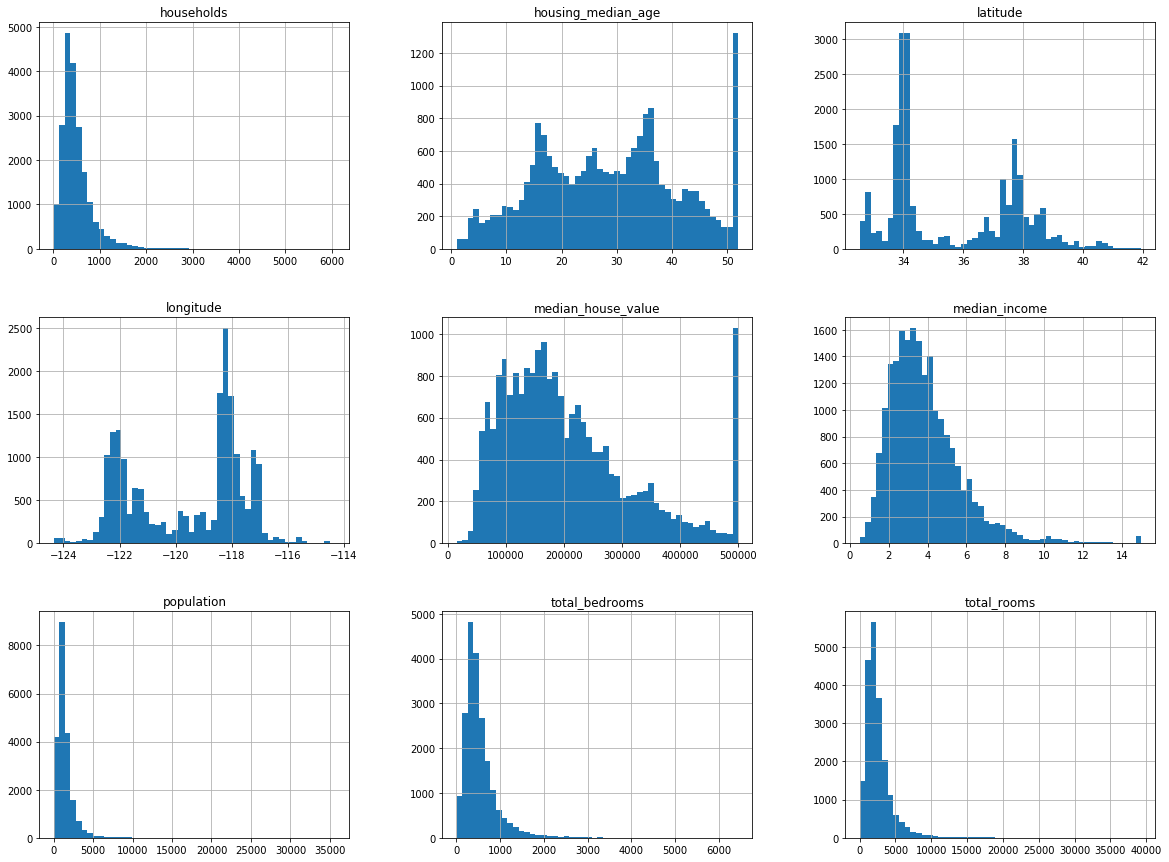

In [79]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Task 2. Plot geo data.

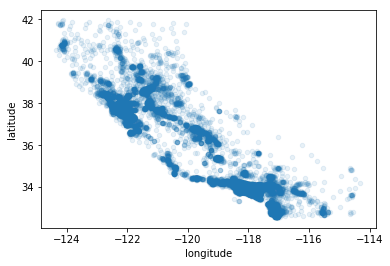

In [80]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

How can we add these points to the acctual map?

How to install packages?

```sh
conda install bokeh
conda install pyproj
```

jeigu conda kartais neranda paketo, galima mėginti `pip install ...`

In [81]:
X, Y = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'),
                 housing['longitude'].values, housing['latitude'].values)
p = figure(x_range=(min(X), max(X)), y_range=(min(Y), max(Y)),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)
source = ColumnDataSource(data=dict(latitude=X, longitude=Y))
p.circle(x="latitude", y="longitude", size=1, color="blue", alpha=0.8, source=source)
show(p)

### Task 3. Use scatter_matrix to explore correlations  

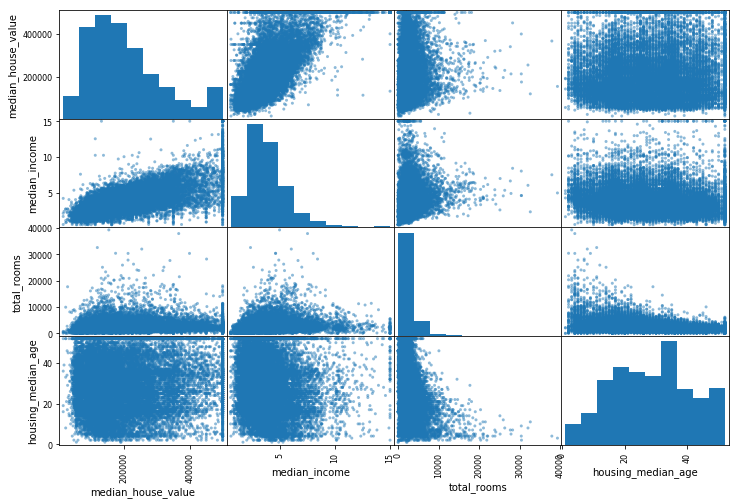

In [82]:
scatter_matrix(housing[["median_house_value", "median_income",
                        "total_rooms", "housing_median_age"]],
               figsize=(12, 8))
plt.show()

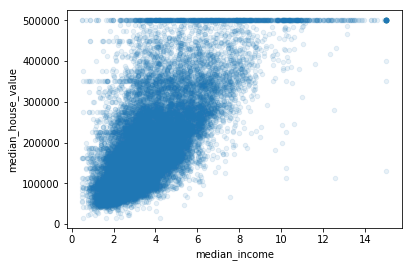

In [83]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

### Task 4. Make simple benchmark model on numeric columns.

What MSE do you get?

Note, that we use *mask* to select train and test sets:

```python
housing[mask]    # select train group
housing[~mask]    # select test group
```

In [84]:
lr = LinearRegression()
lr.fit(housing[mask].drop(['median_house_value', # we drop it because we are predicting it
                           'ocean_proximity',    # we drop it because it is string
                           'total_bedrooms'],    # we drop it because it has missing values
                          axis=1),  # X_train
       housing[mask]['median_house_value'])             # y_train

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [85]:
pred = lr.predict(housing[~mask].drop(['median_house_value', 'ocean_proximity',
                                'total_bedrooms'], axis=1))   # X_test
print('RMSE = {0:.02f}'.format(
    np.sqrt(np.mean((pred - housing[~mask]['median_house_value'])**2))))   # pred - y_test

RMSE = 70300.72


- **Klausimas:** kuris iš stulpų yra svarbiausias?
- **Užuomina:** `lr` yra klasė ir iš jos įmanoma ištraukti koeficientus. Plačiau apie klasę sužinosite parašę `lr?`.

In [92]:
pd.DataFrame(lr.coef_, index=['longitude', 'latitude', 'housing_median_age',
                                'total_rooms', 'population', 'households',
                                'median_income'], columns=['coeficient'])

,coeficient
longitude,-42987.063444
latitude,-42511.470932
housing_median_age,1096.705508
total_rooms,-2.103895
population,-32.143587
households,123.908738
median_income,38915.052567


### Task 5. Add more handcrafter columns.

Try to add easily interpretable columns. Can you improve MSE?

First let's treat **missing** values:

In [14]:
median_total_bedrooms = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median_total_bedrooms, inplace=True)

Now we can create **new columns** as follows:

In [15]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

Let's check if that improves our model

In [17]:
lr = LinearRegression()
lr.fit(housing[mask].drop(['median_house_value', 'ocean_proximity'], axis=1),
       housing[mask]['median_house_value'])
pred = lr.predict(housing[~mask].drop(['median_house_value', 'ocean_proximity'], axis=1))
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - housing[~mask]['median_house_value'])**2))))

RMSE = 69499.10


### Task 6. Use one hot encoder for ocean_proximity

Does it improve RMSE?

In [18]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat = housing[["ocean_proximity"]]
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [19]:
housing = pd.concat([housing, pd.DataFrame(housing_cat_1hot.toarray(),
                    columns=cat_encoder.categories_)], axis=1)

In [20]:
lr = LinearRegression()
lr.fit(housing[mask].drop(['median_house_value', 'ocean_proximity'], axis=1),
       housing[mask]['median_house_value'])
pred = lr.predict(housing[~mask].drop(['median_house_value', 'ocean_proximity'], axis=1))
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - housing[~mask]['median_house_value'])**2))))

RMSE = 68834.00


### Task 7. Reduce MSE by handcrafting even more columns!

You can du much better, this is just a simple example.

In [21]:
housing['bedroom_rate'] = housing["bedrooms_per_room"] / housing["rooms_per_household"]
housing['room_per_person'] = housing["rooms_per_household"] / housing["population_per_household"]

In [22]:
lr = LinearRegression()
lr.fit(housing[mask].drop(['median_house_value', 'ocean_proximity'], axis=1),
       housing[mask]['median_house_value'])
pred = lr.predict(housing[~mask].drop(['median_house_value', 'ocean_proximity'], axis=1))
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - housing[~mask]['median_house_value'])**2))))

RMSE = 67452.28


<BarContainer object of 18 artists>

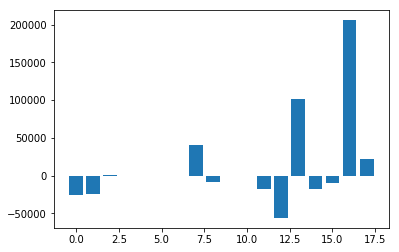

In [23]:
plt.bar(x=range(len(lr.coef_)), height=lr.coef_)

## Scaling features

In [24]:
housing_scaled = housing.drop(['ocean_proximity'], axis=1)
mean = housing_scaled[mask].mean()
std = housing_scaled[mask].std()
# Standard scaler
housing_scaled = (housing_scaled - mean) / std

In [25]:
lr = LinearRegression()
lr.fit(housing_scaled[mask].drop(['median_house_value'], axis=1),
       housing_scaled[mask]['median_house_value'])
pred = lr.predict(housing_scaled[~mask].drop(['median_house_value'], axis=1))
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - housing_scaled[~mask]['median_house_value'])**2))))

RMSE = 0.58


What do we need to do to make prediction comparable?

In [26]:
pred = pred * std['median_house_value'] + mean['median_house_value']
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - housing[~mask]['median_house_value'])**2))))

RMSE = 67452.28


<BarContainer object of 18 artists>

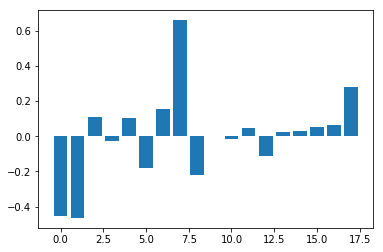

In [27]:
plt.bar(x=range(len(lr.coef_)), height=lr.coef_)

Even though performance is the same, weights are much more interpretable now.

Can we produce similar performance, but gaining much better interpretability?

### Generalized linear models

Instead of using simple Linear regression defined by

$$\min_w ||Xw - y||^2_2$$

we will punish model for using large weights by adding additional term

$$\min_w \frac{1}{2 n_{samples}} ||Xw - y||^2_2 + \alpha ||w||_1.$$

In [110]:
from sklearn.linear_model import Lasso

lr = Lasso(alpha=0.06)
lr.fit(housing_scaled[mask].drop(['median_house_value'], axis=1),
       housing_scaled[mask]['median_house_value'])
pred = lr.predict(housing_scaled[~mask].drop(['median_house_value'], axis=1))
pred = pred * std['median_house_value'] + mean['median_house_value']
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - housing[~mask]['median_house_value'])**2))))

RMSE = 74286.58


<BarContainer object of 18 artists>

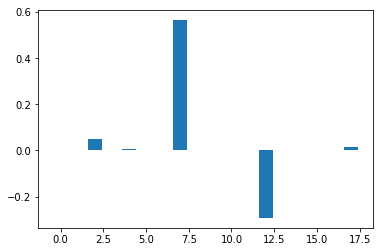

In [111]:
plt.bar(x=range(len(lr.coef_)), height=lr.coef_)

In [133]:
weights = pd.DataFrame(lr.coef_, index=housing_scaled.drop(['median_house_value'], axis=1).columns,
                       columns=['weight'])
weights.loc['intercept'] = lr.intercept_
weights.sort_values('weight', ascending=False).round(6)

,weight
median_income,0.564459
housing_median_age,0.048287
room_per_person,0.015032
total_bedrooms,0.007967
longitude,-0.000000
"(<1H OCEAN,)",-0.000000
bedroom_rate,0.000000
"(NEAR OCEAN,)",0.000000
"(NEAR BAY,)",0.000000
"(ISLAND,)",0.000000


That is powerful especially if interpretability is your focus. It is work to mention other two popular generalized models.

**Ridge regression**

$$\min_w ||Xw - y||^2_2 + \alpha ||w||^2_2$$

**Elastic-Net**

$$\min_w \frac{1}{2n_{samples}} ||Xw - y||^2_2 + \alpha \rho ||w||_1 + \frac{\alpha (1-\rho)}{2} ||w||^2_2$$


If you ara interested read more in [sklearn docs](https://scikit-learn.org/stable/modules/linear_model.html).

### Task 8. Try to use RandomForest

In [143]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(housing[mask].drop(['median_house_value', 'ocean_proximity'], axis=1),
       housing[mask]['median_house_value'])
pred = rf.predict(housing[~mask].drop(['median_house_value', 'ocean_proximity'], axis=1))
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - housing[~mask]['median_house_value'])**2))))

RMSE = 52314.19
